In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib



Data and some clensing methods if you want to test it by yourself set data_for_samplying to 0 : 




    Data: 
    https://data.boston.gov/dataset/climate-ready-boston-social-vulnerability/resource/3d506197-74e9-4032-a455-fe231ea9daf1
    https://data.boston.gov/dataset/building-and-property-violations1?utm_source=chatgpt.com
    https://data.boston.gov/dataset/property-assessment/resource/6b7e460e-33f6-4e61-80bc-1bef2e73ac54




    Data Cleaning: 

    lots of spelling mistakes so had to correct data before merging
    in the districts_df there were a lot of duplicates of the same violation so went in and removed them
    Just in case the merging did not work we also double check and only found 22 unmatched examples so we are good as 22/15000 is a very small unmatched rate
    There were a lot of merging errror so I had to truncate the big files to look at the headers and came up with a 
    new feature that can compare addresses and merge with high success rate. We got around 90% merge collision which is pretty good for data 
    sets collected from different places 
     



In [2]:
#Start by loading the data

data_for_sampling = 1 
if data_for_sampling == 0:

    violations_df = pd.read_csv("./violations.csv")  # violations data 
    demographics_df = pd.read_csv("./demographics.csv")  # social vulnerability dataset
    landlord_df = pd.read_csv("../landlord.csv")  # landlords data


    demographics_df['Name'] = demographics_df['Name'].str.strip().str.lower()
    violations_df['violation_city'] = violations_df['violation_city'].str.strip().str.lower()

    print(demographics_df['Name'].unique())
    print(violations_df['violation_city'].unique())


In [3]:
# Cleaning the data : there are some typos
if data_for_sampling == 0:
    def clean_violation_city(city):
        if pd.isna(city) or city.strip() == '':
            return None
        city = city.lower().strip()
        
        
        city = city.replace('/', '')
        
        if 'boston' in city and city != 'boston':
            return 'boston'
        if 'east boston' in city:
            return 'east boston'
        if 'brighton' in city:
            return 'brighton'
        if 'allston' in city:
            return 'allston'
        if 'fenway' in city or 'kenmore' in city:
            return 'fenway'
        if 'back bay' in city:
            return 'back bay'
        if 'south end' in city or 'bay village' in city:
            return 'south end'
        if 'north end' in city or 'northend' in city:
            return 'north end'
        if 'roxbury' in city:
            return 'roxbury'
        if 'dorchester' in city:
            return 'dorchester'
        if 'hyde park' in city:
            return 'hyde park'
        if 'jamaica plain' in city:
            return 'jamaica plain'
        if 'roslindale' in city:
            return 'roslindale'
        if 'mattapan' in city:
            return 'mattapan'
        if 'west roxbury' in city:
            return 'west roxbury'
        if 'charlestown' in city:
            return 'charlestown'
        if 'south boston' in city:
            return 'south boston'
        if 'theater district' in city or 'financial district' in city or 'chinatown' in city or 'chestnut hill' in city:
            return 'boston'  # Boston neighbourhoods
        return city
    def clean_demographics_name(name):
        if pd.isna(name):
            return None
        name = name.lower().strip()
        name = name.replace('/', '')
        if 'dorchester' in name:
            return 'dorchester'
        if 'brighton' in name:
            return 'brighton'
        if 'roxbury' in name:
            return 'roxbury'
        if 'jamaica plain' in name:
            return 'jamaica plain'
        if 'hyde park' in name:
            return 'hyde park'
        if 'south boston' in name:
            return 'south boston'
        if 'east boston' in name:
            return 'east boston'
        if 'allston' in name:
            return 'allston'
        if 'fenway' in name:
            return 'fenway'
        if 'back bay' in name:
            return 'back bay'
        if 'north end' in name:
            return 'north end'
        if 'west end' in name:
            return 'west end'
        if 'charlestown' in name:
            return 'charlestown'
        if 'south end' in name or 'bay village' in name or 'leather district' in name:
            return 'south end'
        if 'mission hill' in name:
            return 'mission hill'
        if 'west roxbury' in name:
            return 'west roxbury'
        if 'roslindale' in name:
            return 'roslindale'
        if 'mattapan' in name:
            return 'mattapan'
        if 'longwood medical area' in name:
            return 'boston'
        if 'harbor islands' in name:
            return 'boston'
        return name
    # Clean data: 
    violations_df['cleaned_city'] = violations_df['violation_city'].apply(clean_violation_city)
    demographics_df['cleaned_name'] = demographics_df['Name'].apply(clean_demographics_name)
    demographics_df = demographics_df.drop_duplicates(subset=['cleaned_name'])

    # Check: 
    print(violations_df['cleaned_city'].unique())

In [4]:
# Merge data sets 
if data_for_sampling == 0:
    merged_df = violations_df.merge(
        demographics_df,
        left_on='cleaned_city',
        right_on='cleaned_name',
        how='left'
    )

    # Check
    print(merged_df.head())
    # Save 
    merged_df.to_csv("violations_with_demographics.csv", index=False)


In [5]:
# check for some errors 
# Check if there are any violations that did not match to a demographic neighborhood
if data_for_sampling == 0:
    unmatched = merged_df[merged_df['Name'].isna()]
    print(f"There are {len(unmatched)} unmatched violations.")
    if len(unmatched) > 0:
        print(unmatched[['case_no', 'violation_city', 'cleaned_city']])

In [6]:


# Function to clean text (lowercase, remove spaces, remove dots)
if data_for_sampling == 0:
    def clean_text(s):
        if pd.isna(s):
            return ''
        s = str(s).lower()
        s = re.sub(r'\s+', '', s)  # remove all spaces
        s = s.replace('.', '')     # remove dots
        return s

    # Function to clean number fields (like ZIP or ST_NUM) to remove .0
    def clean_number(n):
        if pd.isna(n):
            return ''
        try:
            n = int(float(n))  
        except ValueError:
            return str(n)
        return str(n)

    # Function to clean violation zip specifically (remove leading zeros)
    def clean_violation_zip(z):
        if pd.isna(z):
            return ''
        z = str(z)
        z = z.lstrip('0') 
        return z

    # 1. Load landlord.csv if running locally please be careful on placement of data
    landlord_df = pd.read_csv('/landlord.csv') 

    # 2. Build compare_address for landlord_df
    landlord_df['compare_address'] = (
        landlord_df['ST_NUM'].apply(clean_number).apply(clean_text) +
        landlord_df['ST_NAME'].fillna('').apply(clean_text) +
        landlord_df['ZIP_CODE'].apply(clean_number).apply(clean_text)
    )

    # 3. Load violations_with_demographics.csv
    violations_df = pd.read_csv('./violations_with_demographics.csv')  # adjust path if needed

    # 4. Build compare_address for violations_df
    violations_df['compare_address'] = (
        violations_df['violation_stno'].apply(clean_number).apply(clean_text) +
        violations_df['violation_street'].fillna('').apply(clean_text) +
        violations_df['violation_suffix'].fillna('').apply(clean_text) +
        violations_df['violation_zip'].fillna('').apply(clean_violation_zip).apply(clean_text)
    )

    # 5. Check:
    print("Landlord data (after processing):")
    print(landlord_df[['ST_NUM', 'ST_NAME', 'ZIP_CODE', 'compare_address']].head())

    print("\nViolations data (after processing):")
    print(violations_df[['violation_stno', 'violation_street', 'violation_suffix', 'violation_zip', 'compare_address']].head())

In [7]:
# Merge the now clean data 
if data_for_sampling == 0:
    merged_df = violations_df.merge(
        landlord_df[['compare_address', 'OWNER']],  
        on='compare_address',
        how='left'  
    )

    # Save: 
    merged_df.to_csv('lordsviolation.csv', index=False)

    # Check: 
    print(f"✅ Successfully merged {len(merged_df)} rows!")
    print(f"Total violations: {len(merged_df)}")
    print(f"Violations with OWNER matched: {merged_df['OWNER'].notna().sum()}")
    print(f"Match percentage: {merged_df['OWNER'].notna().mean() * 100:.2f}%")

# Data has been now cleaned we will now work with lordsviolations.csv


In [8]:

# Load processed data on violations and the owners responsible 
df = pd.read_csv('../Data/lordsviolation.csv')

# Clean: 
df = df[df['OWNER'].notna()]

# Group by owner
violation_counts = df.groupby(['OWNER', 'description']).size().reset_index(name='count')

# Gropu on violaiton severity by owner
violation_stats = df.groupby('OWNER').agg({
    'case_no': 'count',
    'code': ['nunique', 'min', 'max']
}).reset_index()

violation_stats.columns = ['OWNER', 'total_violations', 'unique_violation_types', 'min_code', 'max_code']

# Merge
landlord_summary = pd.merge(violation_stats, violation_counts, on='OWNER', how='left')

# Sort
worst_landlords = landlord_summary.sort_values(by='total_violations', ascending=False)

# Check
print(worst_landlords.head(10))

# Save: 
if data_for_sampling == 0:
    worst_landlords.to_csv('worst_landlords_violation_summary.csv', index=False)

                                   OWNER  total_violations  \
10722               HISTORIC RIVIERA LLC               150   
10723               HISTORIC RIVIERA LLC               150   
19873                    SANIEOFF KHORSO                70   
19872                    SANIEOFF KHORSO                70   
19871                    SANIEOFF KHORSO                70   
19870                    SANIEOFF KHORSO                70   
15883          MOTHER BROOK LLC MASS LLC                50   
15884          MOTHER BROOK LLC MASS LLC                50   
15882          MOTHER BROOK LLC MASS LLC                50   
23520  WALANDO HOMES LIMITED PARTNERSHIP                47   

       unique_violation_types  min_code max_code  \
10722                       2   105.1.1    116.2   
10723                       2   105.1.1    116.2   
19873                       5  1001.3.2    121.1   
19872                       5  1001.3.2    121.1   
19871                       5  1001.3.2    121.1   
19870

# Visualizations

In [9]:

# Visualizations

df = pd.read_csv("../Data/lordsviolation.csv")

# Summary: 
summary = (
    df.groupby(['OWNER', 'description'])
    .size()
    .reset_index(name='count')
)

# Total counter violations
summary['total_violations'] = summary.groupby('OWNER')['count'].transform('sum')

# Save
if data_for_sampling == 0:
    summary.to_csv("worst_landlords_violation_summary.csv", index=False)

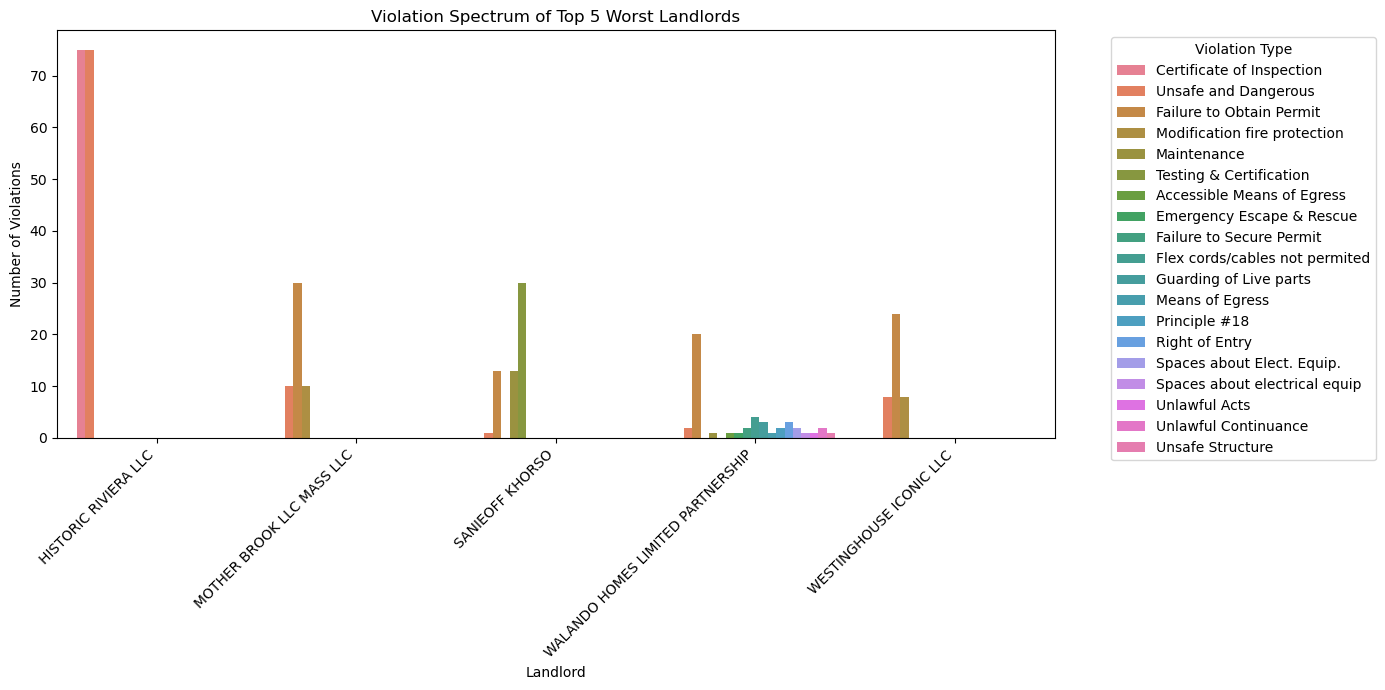

In [10]:


summary_df = pd.read_csv("../Data/worst_landlords_violation_summary.csv")

# Top 5 worst landlords 
top_landlords = (
    summary_df.groupby("OWNER")["total_violations"]
    .max()
    .sort_values(ascending=False)
    .head(5)
    .index
)

top_summary = summary_df[summary_df["OWNER"].isin(top_landlords)]

plt.figure(figsize=(14, 7))
sns.barplot(data=top_summary, x="OWNER", y="count", hue="description")
plt.title("Violation Spectrum of Top 5 Worst Landlords")
plt.xlabel("Landlord")
plt.ylabel("Number of Violations")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Violation Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

output_dir = "../Visualizations/q2"
output_path = os.path.join(output_dir, "landlord_violations.png")
os.makedirs(output_dir, exist_ok=True)
plt.savefig(output_path, dpi=300)

plt.show()

# Some learning algorithms: 

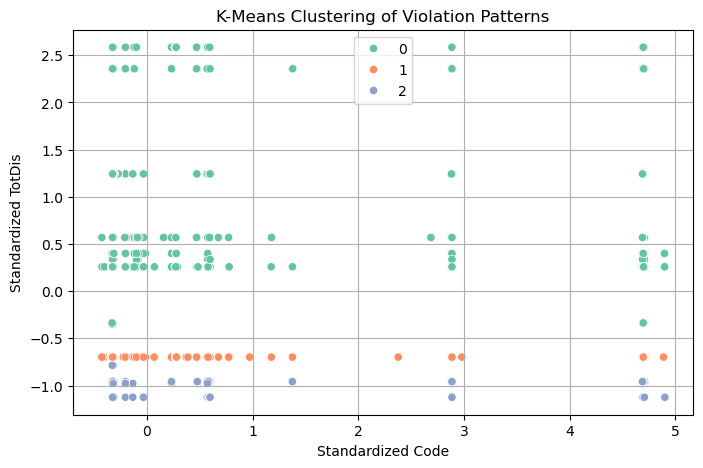

In [11]:

# Load data
df = pd.read_csv("../Data/lordsviolation.csv")

# Clean
df['code'] = pd.to_numeric(df['code'], errors='coerce')

# Features: 
features = ['code', 'TotDis', 'TotChild', 'OlderAdult', 'Low_to_No', 'LEP', 'POC2', 'MedIllnes']
X = df[features].dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
df.loc[X.index, 'cluster'] = cluster_labels  # only assign to rows we used

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=cluster_labels, palette='Set2')
plt.title("K-Means Clustering of Violation Patterns")
plt.xlabel("Standardized Code")
plt.ylabel("Standardized TotDis")
plt.grid(True)

output_dir = "../Visualizations/q2"
output_path = os.path.join(output_dir, "kmeans_violationspatterns.png")
os.makedirs(output_dir, exist_ok=True)
plt.savefig(output_path, dpi=300)

plt.show()


In [12]:
# Logistic Regression: Predicting if a landlord is a repeat offender




violation_counts = df.groupby('OWNER').size().reset_index(name='violation_count')
df = df.merge(violation_counts, on='OWNER', how='left')
df['worst_landlord'] = (df['violation_count'] >= 5).astype(int)

# Model data
features = ['code', 'TotDis', 'TotChild', 'OlderAdult', 'Low_to_No', 'LEP', 'POC2', 'MedIllnes']
X = df[features].fillna(0)
y = df['worst_landlord']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

output_dir = "../models/q2"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "logistic_regression_model.joblib")
joblib.dump(clf, model_path)
# Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      5629
           1       0.57      0.13      0.21      1861

    accuracy                           0.76      7490
   macro avg       0.67      0.55      0.53      7490
weighted avg       0.72      0.76      0.70      7490



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
